In [1]:
from IPython import display
from pathlib import Path
import shutil
import yaml

display.clear_output()

# Load config
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Prevent ultralytics from tracking activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()
from tqdm import tqdm

Ultralytics 8.4.14 🚀 Python-3.13.11 torch-2.10.0 CPU (Apple M3 Pro)
Setup complete ✅ (11 CPUs, 36.0 GB RAM, 283.0/460.4 GB disk)


In [2]:
# Validate Phase 4 input
age_filtered_path = Path(f"../{config['paths']['age_filtered']}")
age_filtered_count = len(list(age_filtered_path.glob('*.png')))
print(f"Phase 4 output (age-filtered images): {age_filtered_count} images")

if age_filtered_count == 0:
    print("\nWARNING: No age-filtered images from Phase 4!")
    print(f"Expected path: {age_filtered_path}")
    print("Run Phase 4 (04_age_estimation.ipynb) first to generate input images.")

Phase 4 output (age-filtered images): 172 images


note: advertisement images: crop 63, 990

# Phase 5: Advertisement Detection

Method: OCR-based text analysis using EasyOCR to extract text and detect promotional keywords.

Method selection: OCR
- Advertisements contain promotional language (SALE, OFFER, DISCOUNT, etc.)
- OCR captures this signal robustly without fine-tuning
- Generalizable: keyword list works across datasets
- Interpretable: can see exactly which text triggered detection

Alternative: CLIP <br>
Tested CLIP (ViT-B-32) with multiple prompts—all scores clustered ~0.12-0.13, unable to separate ads from natural photos without fine-tuning.

### Keywords & Configuration

OCR Model: EasyOCR
- Efficient text detection and recognition across 80+ languages
- Pre-trained, no fine-tuning needed
- Lightweight compared to deep learning alternatives

Promotional Keywords: "SALE", "OFFER", "DISCOUNT", "%OFF", "LIMITED", "BUY"

- Rationale: Specific to commercial/promotional intent, unlikely on casual shirt text alone- Tuning guidance: If too many false positives → increase keyword count threshold; if missing ads → add more keywords

- Generalization: Works across ad types (clothing, products, services) without dataset-specific tuning- Case-insensitive matching

- Trade-off: May miss ads without promotional text (catalog-style). may flag promotions unrelated to ads- Flag as ad if ANY promotional keyword detected (conservative: keyword threshold = 1)

---
## Implementation

In [3]:
import cv2
import numpy as np
from PIL import Image
import easyocr

## Load OCR Model

In [4]:
# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=False)

# Promotional keywords to detect advertisements
promotional_keywords = [
    'sale', 'offer', 'discount', 'off', 'limited',
    'buy', 'price', 'promotion', 'deal', 'promo',
    'save', 'free', 'new', 'now', 'shop', 'order',
    'collection', 'exclusive', '%', '$', '€', '£'
 ]

# OCR confidence threshold (from config or default)
ocr_confidence_threshold = config.get('ocr_confidence_threshold', 0.3)


print(f"Loaded EasyOCR reader for English")
print(f"  Keyword threshold: 1 (detect ad if 1+ high-confidence keywords found)")

print(f"  Promotional keywords: {promotional_keywords}")
print(f"  OCR confidence threshold: {ocr_confidence_threshold}")

Using CPU. Note: This module is much faster with a GPU.


Loaded EasyOCR reader for English
  Keyword threshold: 1 (detect ad if 1+ high-confidence keywords found)
  Promotional keywords: ['sale', 'offer', 'discount', 'off', 'limited', 'buy', 'price', 'promotion', 'deal', 'promo', 'save', 'free', 'new', 'now', 'shop', 'order', 'collection', 'exclusive', '%', '$', '€', '£']
  OCR confidence threshold: 0.3


## Define OCR Detection Function

In [ ]:
def detect_advertisement_ocr(img_path, reader, keywords, confidence_threshold=0.3):
    """
    Detect advertisements by extracting text and checking for promotional keywords.
    
    Args:
        img_path: Path to image file
        reader: EasyOCR reader instance
        keywords: List of promotional keywords to search for
        confidence_threshold: Minimum OCR confidence (0-1) to count a keyword match (default 0.3)
    
    Returns:
        dict: {
            'is_advertisement': bool,
            'detected_text': str (all extracted text),
            'matched_keywords': list (keywords found in image),
            'confidence': float (highest OCR confidence for matched keywords)
        }
    """
    try:
        # Normalize keyword list (handles accidental nesting)
        normalized_keywords = []
        for kw in keywords:
            if isinstance(kw, (list, tuple, set)):
                normalized_keywords.extend([str(k) for k in kw])
            else:
                normalized_keywords.append(str(kw))
        
        # Read image and extract text
        results = reader.readtext(str(img_path))
        
        if not results:
            # No text detected
            return {
                'is_advertisement': False,
                'detected_text': '',
                'matched_keywords': [],
                'confidence': 0.0
            }
        
        # Extract all text and confidence scores
        full_text = ' '.join([text for (bbox, text, conf) in results])
        full_text_upper = full_text.upper()
        
        # Check for promotional keywords with confidence threshold
        matched_keywords = []
        max_confidence = 0.0
        
        for keyword in normalized_keywords:
            if keyword.upper() in full_text_upper:
                # Find confidence for this keyword match
                for (bbox, text, conf) in results:
                    if keyword.upper() in text.upper():
                        max_confidence = max(max_confidence, conf)
                # Only count keyword if confidence meets threshold
                if max_confidence >= confidence_threshold:
                    matched_keywords.append(keyword)
        
        # Flag as advertisement if any high-confidence promotional keywords found
        is_advertisement = len(matched_keywords) > 0
        
        return {
            'is_advertisement': is_advertisement,
            'detected_text': full_text,
            'matched_keywords': matched_keywords,
            'confidence': max_confidence
        }
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return {
            'is_advertisement': False,
            'detected_text': '',
            'matched_keywords': [],
            'confidence': 0.0
        }

OCR advertisement detection function defined
OCR advertisement detection function defined
OCR advertisement detection function defined


## Run Advertisement Detection

In [7]:
# Load age-filtered images from Phase 4
age_filtered_path = Path(f"../{config['paths']['age_filtered']}")
age_filtered_names = sorted([f.name for f in age_filtered_path.glob('*.png')])

print(f"Found {len(age_filtered_names)} age-filtered images from Phase 4")

Found 172 age-filtered images from Phase 4


In [9]:
# Suppress torch/MPS warnings
import warnings
warnings.filterwarnings('ignore', message='.*pin_memory.*')

# Run OCR advertisement detection on all images
all_results = {}

for img_name in tqdm(age_filtered_names, desc="Detecting advertisements (OCR)"):
    img_path = age_filtered_path / img_name
    
    if not img_path.exists():
        continue
    
    # Run OCR detection with configured confidence threshold
    result = detect_advertisement_ocr(img_path, reader, promotional_keywords, confidence_threshold=ocr_confidence_threshold)
    
    all_results[img_name] = {
        'is_advertisement': result['is_advertisement'],
        'detected_text': result['detected_text'],
        'matched_keywords': result['matched_keywords'],
        'confidence': result['confidence']
    }

# Summary
passes_count = sum(1 for r in all_results.values() if not r['is_advertisement'])
total_count = len(all_results)
coverage = (passes_count / total_count * 100) if total_count > 0 else 0
ads_count = total_count - passes_count

print(f"Advertisement detection results (OCR):")
print(f"  Natural photos (kept): {passes_count}/{total_count} ({coverage:.1f}%)")
print(f"  Advertisements (rejected): {ads_count}")

Detecting advertisements (OCR): 100%|██████████| 172/172 [01:07<00:00,  2.54it/s]

Advertisement detection results (OCR):
  Natural photos (kept): 172/172 (100.0%)
  Advertisements (rejected): 0


In [ ]:
# List detected advertisements
ad_images = {name: result for name, result in all_results.items() if result['is_advertisement']}

print(f"Detected advertisements ({len(ad_images)} total):")

for img_name in sorted(ad_images.keys()):
    result = ad_images[img_name]
    keywords_str = ', '.join(result['matched_keywords']) if result['matched_keywords'] else 'None'
    print(f"  {img_name}")
    print(f"    Keywords: {keywords_str}")
    print(f"    Text: {result['detected_text'][:100]}..." if len(result['detected_text']) > 100 else f"    Text: {result['detected_text']}")

Detected advertisements (0 total):


In [11]:
# Save ad-filtered images
ad_filtered_path = Path(f"../{config['paths']['ad_filtered']}")
if ad_filtered_path.exists():
    shutil.rmtree(ad_filtered_path)
ad_filtered_path.mkdir(exist_ok=True, parents=True)

saved_count = 0
for img_name, result in all_results.items():
    if not result['is_advertisement']:
        source_path = age_filtered_path / img_name
        shutil.copy(source_path, ad_filtered_path / img_name)
        saved_count += 1

print(f"Saved {saved_count} ad-filtered images to: {config['paths']['ad_filtered']}")

Saved 172 ad-filtered images to: data/final


In [12]:
# Verify
final_image_count = len(list(ad_filtered_path.glob('*.png')))
print(f"Total in ad_filtered (final dataset): {final_image_count}")

Total in ad_filtered (final dataset): 172


## Visualisation

Visualize the two known advertisement crops

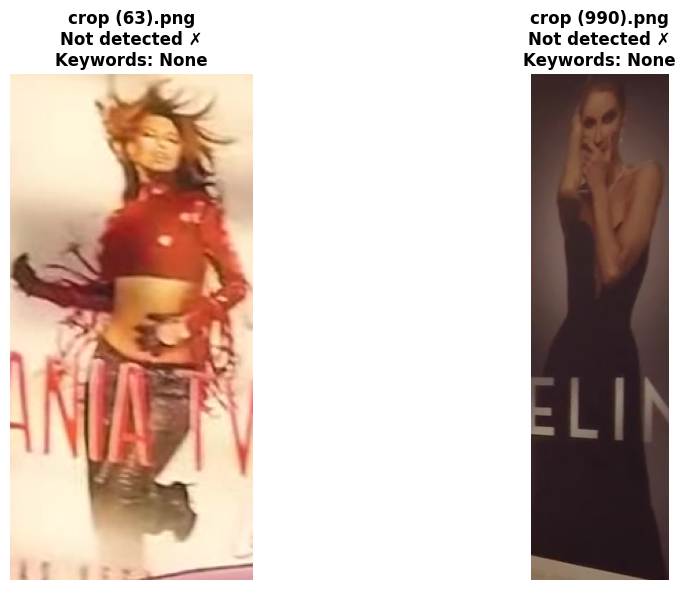

These are the known advertisement crops that should be detected.


In [13]:
import matplotlib.pyplot as plt

crops_to_visualize = ['crop (63).png', 'crop (990).png']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for idx, crop_name in enumerate(crops_to_visualize):
    img_path = age_filtered_path / crop_name
    img = cv2.imread(str(img_path))
    
    if img is not None and crop_name in all_results:
        result = all_results[crop_name]
        axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        keywords_str = ', '.join(result['matched_keywords']) if result['matched_keywords'] else 'None'
        is_ad_str = "AD ✓" if result['is_advertisement'] else "Not detected ✗"
        title = f"{crop_name}\n{is_ad_str}\nKeywords: {keywords_str}"
        axes[idx].set_title(title, fontsize=12, fontweight='bold')
        axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, f"{crop_name} not found", ha='center', va='center')
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("These are the known advertisement crops that should be detected.")

In [14]:
# Visualize rejected advertisements (first 10)
ad_images = {name: result for name, result in all_results.items() if result['is_advertisement']}

print(f"Rejected advertisements ({len(ad_images)} total):")

if ad_images:
    # Limit to first 10 images
    ad_items = list(ad_images.items())[:10]
    num_images = len(ad_items)
    
    cols = min(4, num_images)  # Max 4 columns
    rows = (num_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    
    # Flatten axes for easy iteration
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1 or cols == 1:
        axes = axes.reshape(rows, cols)
    
    axes = axes.flatten()
    
    for idx, (img_name, result) in enumerate(ad_items):
        img_path = age_filtered_path / img_name
        img = cv2.imread(str(img_path))
        
        if img is not None:
            axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            keywords_str = ', '.join(result['matched_keywords']) if result['matched_keywords'] else 'None'
            title = f"{img_name}\nKeywords: {keywords_str}\nConf: {result['confidence']:.2f}"
            axes[idx].set_title(title, fontsize=9, fontweight='bold', color='red')
            axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(len(ad_items), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nDisplayed {len(ad_items)} of {len(ad_images)} rejected advertisements")
    print("These images were flagged as advertisements by OCR")
else:
    print("No advertisements detected!")

Rejected advertisements (0 total):
No advertisements detected!


## Test on advertisements

Found 14 sample advertisement images
2016-Colgate-Print-Advertisement-732x1024.jpeg
  Keywords: new | ✓ AD DETECTED
2acceefd0b17d04a85018978ab2c5003.jpg
  Keywords: None | ✗ Not detected
360_F_1487810777_OWSspeK9yrSN7LismeIVqpyh769mzu9H.jpg
  Keywords: None | ✗ Not detected
97719750-super-fashion-sale-advertising-billboard-on-bus-station.jpg
  Keywords: off | ✓ AD DETECTED
PV5-1.webp
  Keywords: off, new, $ | ✓ AD DETECTED
Pull-Tab-Wild-Posting-Street-Pole-Advertising-Chicago-copy.jpeg
  Keywords: None | ✗ Not detected
ad123.png
  Keywords: now, % | ✓ AD DETECTED
being-human-being-extra-ordinary-humans-new-arrivals-now-in-store-ad-hyderabad-times-10-03-2018 (1).png
  Keywords: new, now, shop | ✓ AD DETECTED
being-human-being-extra-ordinary-humans-new-arrivals-now-in-store-ad-hyderabad-times-10-03-2018.png
  Keywords: new, now, shop | ✓ AD DETECTED
being-human-new-arrivals-now-in-store-ad-bombay-times-11-08-2019.jpg
  Keywords: new, now, shop | ✓ AD DETECTED
image114.jpg
  Keywords: off

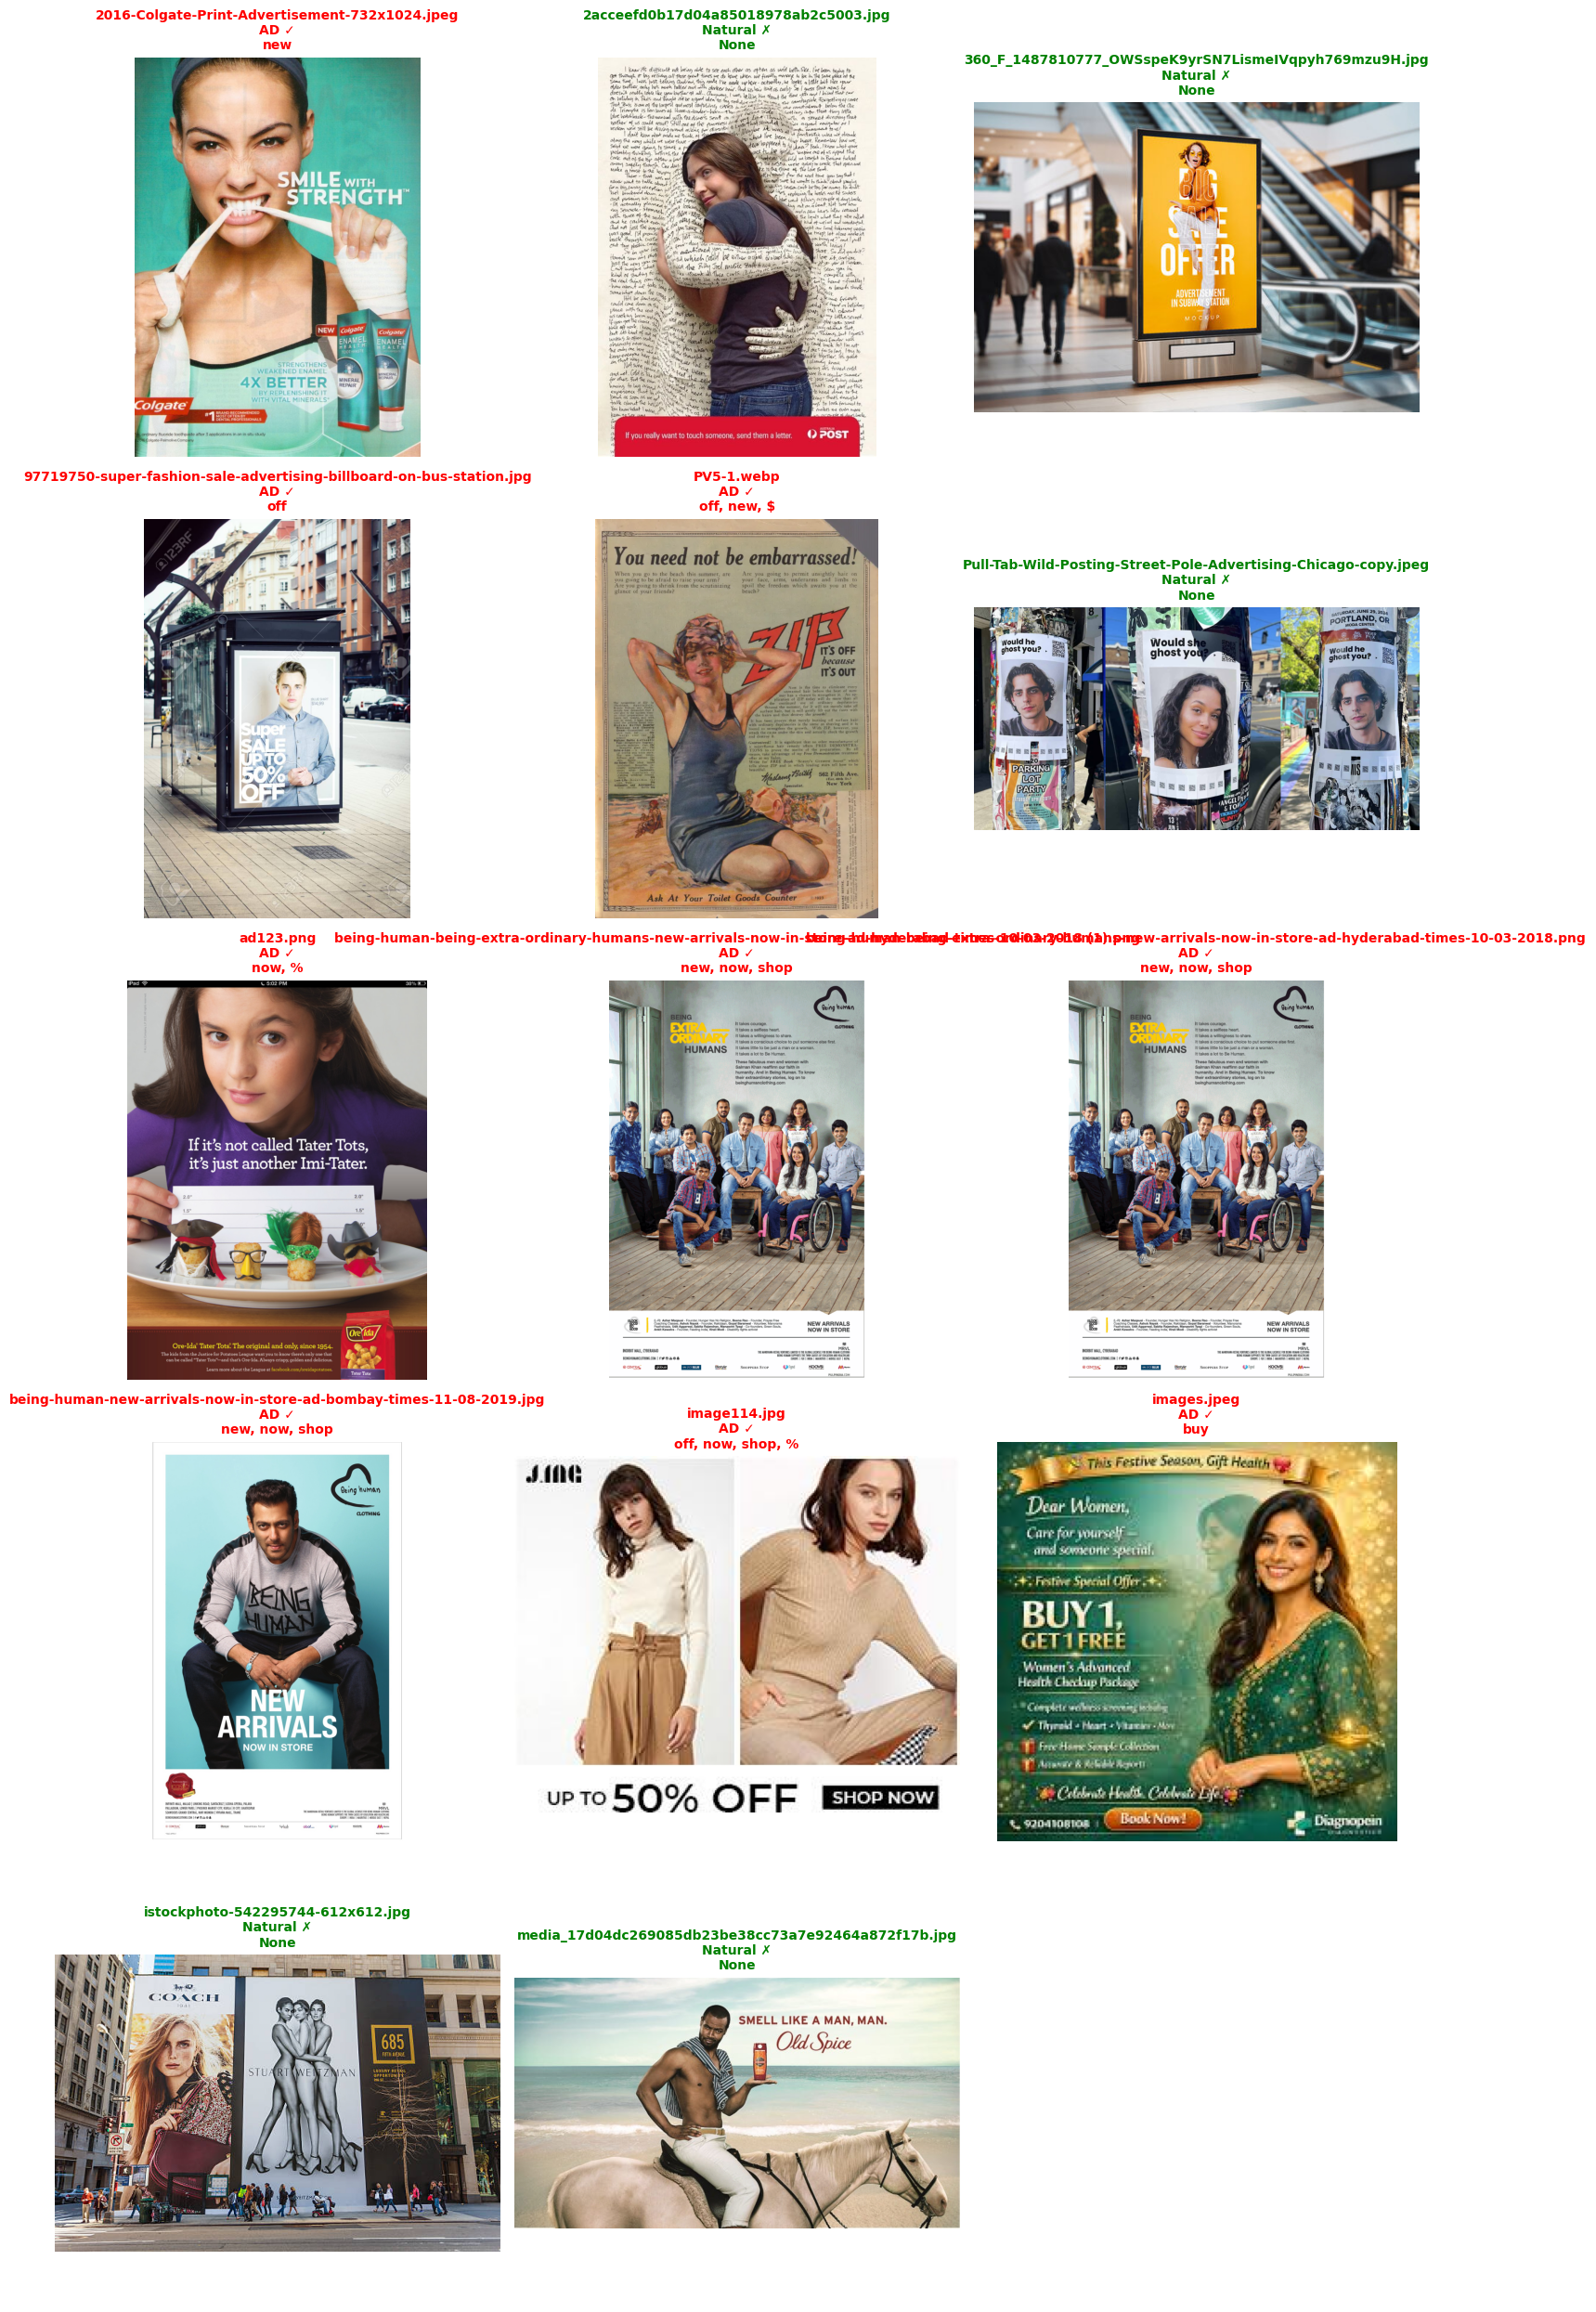

In [16]:
# Test OCR on sample advertisements folder
sample_ad_path = Path("./sample_advertisements")

if not sample_ad_path.exists():
    print(f"ERROR: {sample_ad_path} not found")
    print(f"Absolute path: {sample_ad_path.resolve()}")
else:
    # Support multiple image formats
    image_patterns = ['*.png', '*.jpg', '*.jpeg', '*.webp', '*.PNG', '*.JPG', '*.JPEG']
    sample_images = []
    for pattern in image_patterns:
        sample_images.extend(sorted(sample_ad_path.glob(pattern)))
    
    # Remove duplicates and sort
    sample_images = sorted(list(set(sample_images)))
    
    print(f"Found {len(sample_images)} sample advertisement images")
    print("="*70)
    
    test_results = {}
    
    for img_file in sample_images:
        if img_file.exists():
            result = detect_advertisement_ocr(img_file, reader, promotional_keywords)
            test_results[img_file.name] = result
            
            keywords_str = ', '.join(result['matched_keywords']) if result['matched_keywords'] else 'None'
            is_ad_str = "✓ AD DETECTED" if result['is_advertisement'] else "✗ Not detected"
            print(f"{img_file.name}")
            print(f"  Keywords: {keywords_str} | {is_ad_str}")
        else:
            print(f"{img_file.name}: FAILED to read")
    
    print("="*70)
    
    # Visualize results
    if test_results:
        num_images = len(test_results)
        cols = min(3, num_images)
        rows = (num_images + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
        if rows == 1 and cols == 1:
            axes = np.array([[axes]])
        elif rows == 1 or cols == 1:
            axes = axes.reshape(rows, cols)
        axes = axes.flatten()
        
        for idx, (img_name, result) in enumerate(test_results.items()):
            img_path = sample_ad_path / img_name
            img = cv2.imread(str(img_path))
            
            if img is not None:
                axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                
                is_ad_label = "AD ✓" if result['is_advertisement'] else "Natural ✗"
                keywords_str = ', '.join(result['matched_keywords']) if result['matched_keywords'] else 'None'
                title = f"{img_name}\n{is_ad_label}\n{keywords_str}"
                title_color = 'red' if result['is_advertisement'] else 'green'
                axes[idx].set_title(title, fontsize=10, fontweight='bold', color=title_color)
                axes[idx].axis('off')
        
        for idx in range(len(test_results), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()

## CLIP Approach - Why It Failed

**Experimentation Summary:**
- Tested CLIP (ViT-B-32) with multiple prompt variations (conceptual and visual descriptors)
- All scores clustered around 0.12-0.13 for both "advertisement" and "natural photo" prompts
- Known advertisements (crop 63, 990) and 9 sample ads all scored similarly (~0.127-0.131) and were not detected

**Root Cause:**
- CLIP is pre-trained on general image-text pairs and doesn't encode a strong semantic distinction between "advertisements" and "candid natural photos"
- The low absolute similarity scores indicate weak alignment with any of our prompts
- Prompt engineering alone cannot overcome this fundamental limitation

**Conclusion:**
CLIP is not suitable for this task. The model lacks the specific visual understanding needed to distinguish ads from natural photos without fine-tuning on domain-specific data.